# Introduction

For the past year, the IAF has been collecting data from an observation baloon.
The data is composed of 2 types of files:
1. Telemetry - this dataset contains general operational data such as height, pitch and roll of the baloon, pressure sensors and temperature sensors.
2. FBG - this dataset contains only data of the optic fibers that measure streching and shrinking of the baloon's fabric. there are 4 optic fibers, all around the same spot of the baloon, which for classified reasons we cannot elaborate more about. These fibers are important for calculating the load on that specific spot of the baloon because we don't want it to rip.

In this project we will be building a regression model for the fibers based on the telemetry data. The regression model will be built only for one of the optic fibers in order to focus the scope of the project (also the 4 fibers have very high correlation, so its fine to assume they have similar behaviors).

The motivation for this study model is finding a way to replace the functionality of the fibers using sensors that are permenantly attached to the baloon. That way, we can remove the fibers from their current location and attach them at different places on the baloon. By repeating this process multiple times we can eventualy have a regression model for the amount of load on the baloon at each point we model without farther need in the fibers.

# Preprocessing

In this section we will import the data files and merge them into a main DF with which we will be working.
the steps we will take are:
1. importing all of the telemetry files and creating a telemetry DF
2. importing all of the FBG files and creating a FBG DF
3. merging both DFs - here we must point out that both datasets have a timestamp that we will merge on. also, the clocks of the datasets are not synchronized, they have a lag of 2 hours minus 35 seconds (this info came from the system engineer).


In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
import os
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

Load and process telemetry data

In [2]:
#we will have to loop over all the telemetry files using the "os" library
#notice the date of each telemetry file is encoded in its name. for example, file "HAAS_211125" is from 25.11.2021

teleDF = pd.DataFrame()
tele_path = r'C:\Users\tamir\Desktop\joni project\data\telemetry'
for file in os.listdir(tele_path):
    temp = pd.read_csv(tele_path+'\\'+file) #this is a temporary DF to keep the data of each file
    fname = file.split('.')[0].split('_')[1]
    year = int('20' + fname[:2])
    month = int(fname[2:4])
    day = int(fname[4:])
    #adding a timestamp to each row:
    tstamp = pd.DataFrame()
    tstamp = temp.apply(lambda row: datetime.datetime(year, month, day,
                                                      int(row['GPSCompassUTCHoursValue']),
                                                      int(row['GPSCompassUTCMinutesValue']),
                                                      int(row['GPSCompassUTCSecondsValue'])), axis=1)
    temp['time'] = tstamp
    #append the temporary DF to teleDF
    teleDF = teleDF.append(temp)

#now that we have our full telemetry data in teleDF
#we can now use the timestamp as an index, but first we need to push the timestamps foreward 2 hours minus 35 seconds
#in order to sync it to the FBG data (that we will import when we finish with teleDF)
#after doing so, we will set the timestamp as index and erase the other columns containing time related info.
teleDF['time'] = teleDF['time'] + datetime.timedelta(hours=2, seconds=-35)
teleDF = teleDF.set_index('time')
teleDF = teleDF.drop(columns=['GPSCompassUTCHoursValue', 'GPSCompassUTCMinutesValue', 'GPSCompassUTCSecondsValue'])

#there are 2 last things we need to do before teleDF is complete:
#1. delete 'GPSCompassAerostatAltitude' because it is corupt (this is info from the system enguneer)
teleDF = teleDF.drop(columns=['GPSCompassAerostatAltitude'])
#2. we are only interested in the data when the baloon is in the air, so we only need the samples where the nose latch is open
teleDF = teleDF[teleDF['NoseLatchStatusValue']==0]
#from this point on the nose latch parameter is of no interest because it will always be zero, we can delete it
teleDF = teleDF.drop(columns=['NoseLatchStatusValue'])

#lets look at some stats:
print('The shape of teleDF: '+str(teleDF.shape)+'\n\n')
#teleDF.head(10)

#free up space by deleting temp
del temp

The shape of teleDF: (123656, 44)




Load and process FBG data

there are a couple of issues we need to deel with here:
1. the first 59 rows of these text files are irrelevent metadata
2. the optic fibers are sampled 10 times faster than the telemetry data, so in order to save memory we will read every 10th sample only.(telemetry is sampled every 1 sec and FBG every 0.1 sec)
3. the columns that interest us are the 4 'ballonet' sensors (these are the optic fibers) and the timestamp column. the 'ballonet' names are: 'ballonet_right_fwd', 'ballonet_right_Aft', 'ballonet_left_fwd', 'ballonet_left_Aft'. for this research, we will be building a regression model only for one of these sensors, as stated before. 'ballonet_right_Aft' was chosen at random, and this will be the only sensor that we will be reading from the file due to lack of memmory.



In [3]:
mainDF = pd.DataFrame()
fbg_path = r'C:\Users\tamir\Desktop\joni project\data\FBG'
for file in os.listdir(fbg_path):
    #read the FBG data 
    temp = pd.read_csv(fbg_path+'\\'+file, skiprows=59,
                       sep='\t', usecols=['Timestamp', 'ballonet_right_Aft'])
    #take every 10th row of the data (decrease sample rate to every 1 sec)
    temp = temp[temp.index%10 == 0]
    #turn the timestamp column into an actual timestamp
    temp['Timestamp']= pd.to_datetime(temp['Timestamp'])
    #round the timestamp to 1 sec
    temp['Timestamp'] = temp['Timestamp'].dt.round('1s')
    #set timestamp as index
    temp = temp.set_index('Timestamp')
    #now we need to merge the FBG data in "temp" into the telemetry data by timestamp
    #we need to use an outer join in order to not get duplicates (there might be more FBG data then telemetry data)
    merged = (temp.sort_index()).merge(teleDF.sort_index(),
                                       how='right',
                                       right_index=True,
                                       left_index=True)
    merged = merged.dropna()
    print('\nFinished merging file: '+str(file))
    print('the shape is: ')
    print(merged.shape)
    #now we append the finished merged DF to mainDF
    mainDF = mainDF.append(merged)
    del temp
    
#lets look at some stats:
print('The shape of mainDF: '+str(mainDF.shape)+'\n\n')
#fbgDF.head(10)


Finished merging file: Sensors.20211124231644.txt
the shape is: 
(73597, 45)

Finished merging file: Sensors.20211201000000.txt
the shape is: 
(0, 45)

Finished merging file: Sensors.20211209154029.txt
the shape is: 
(2691, 45)

Finished merging file: Sensors.20220101000000.txt
the shape is: 
(13053, 45)
The shape of mainDF: (89341, 45)




Because this is a big file, the first thing we will do is save it as a pkl, that way we can later upload it faster.

__DISCLAIMER - the loading process of te FBG data took a long time (~1 hour). If you want to load the data we recomend loading the pkl and not loading the raw files.__

In [4]:
save_path = r'C:\Users\tamir\Desktop\joni project\data'
mainDF.to_pickle(save_path + '\\' + 'mainDF.pkl')

# Data Exploration

In this section we explore our feature space.
We will be doing so by looking at correlation of the features amongst themselves and correlations between the features and the target variable. We will see if there are any variables we can drop using the correlation and our domain knowledge of the data.

In [5]:
#loading the DF from the pkl file
save_path = r'C:\Users\tamir\Desktop\joni project\data'
mainDF = pd.read_pickle(save_path + '\\' + 'mainDF.pkl')

Text(0.5, 0, 'Strain')

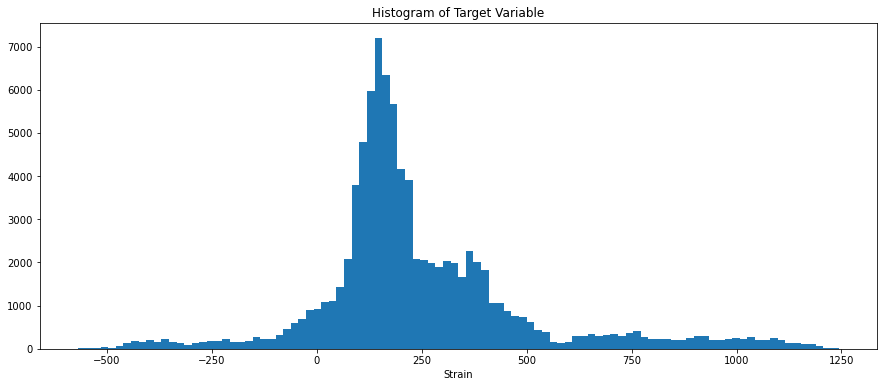

In [32]:
#first, to check we dont have any discreptencies, we take a look at the target variable
plt.figure(figsize = (15,6))
plt.hist(mainDF['ballonet_right_Aft'], bins=100);
plt.title('Histogram of Target Variable')
plt.xlabel('Strain')

<AxesSubplot:>

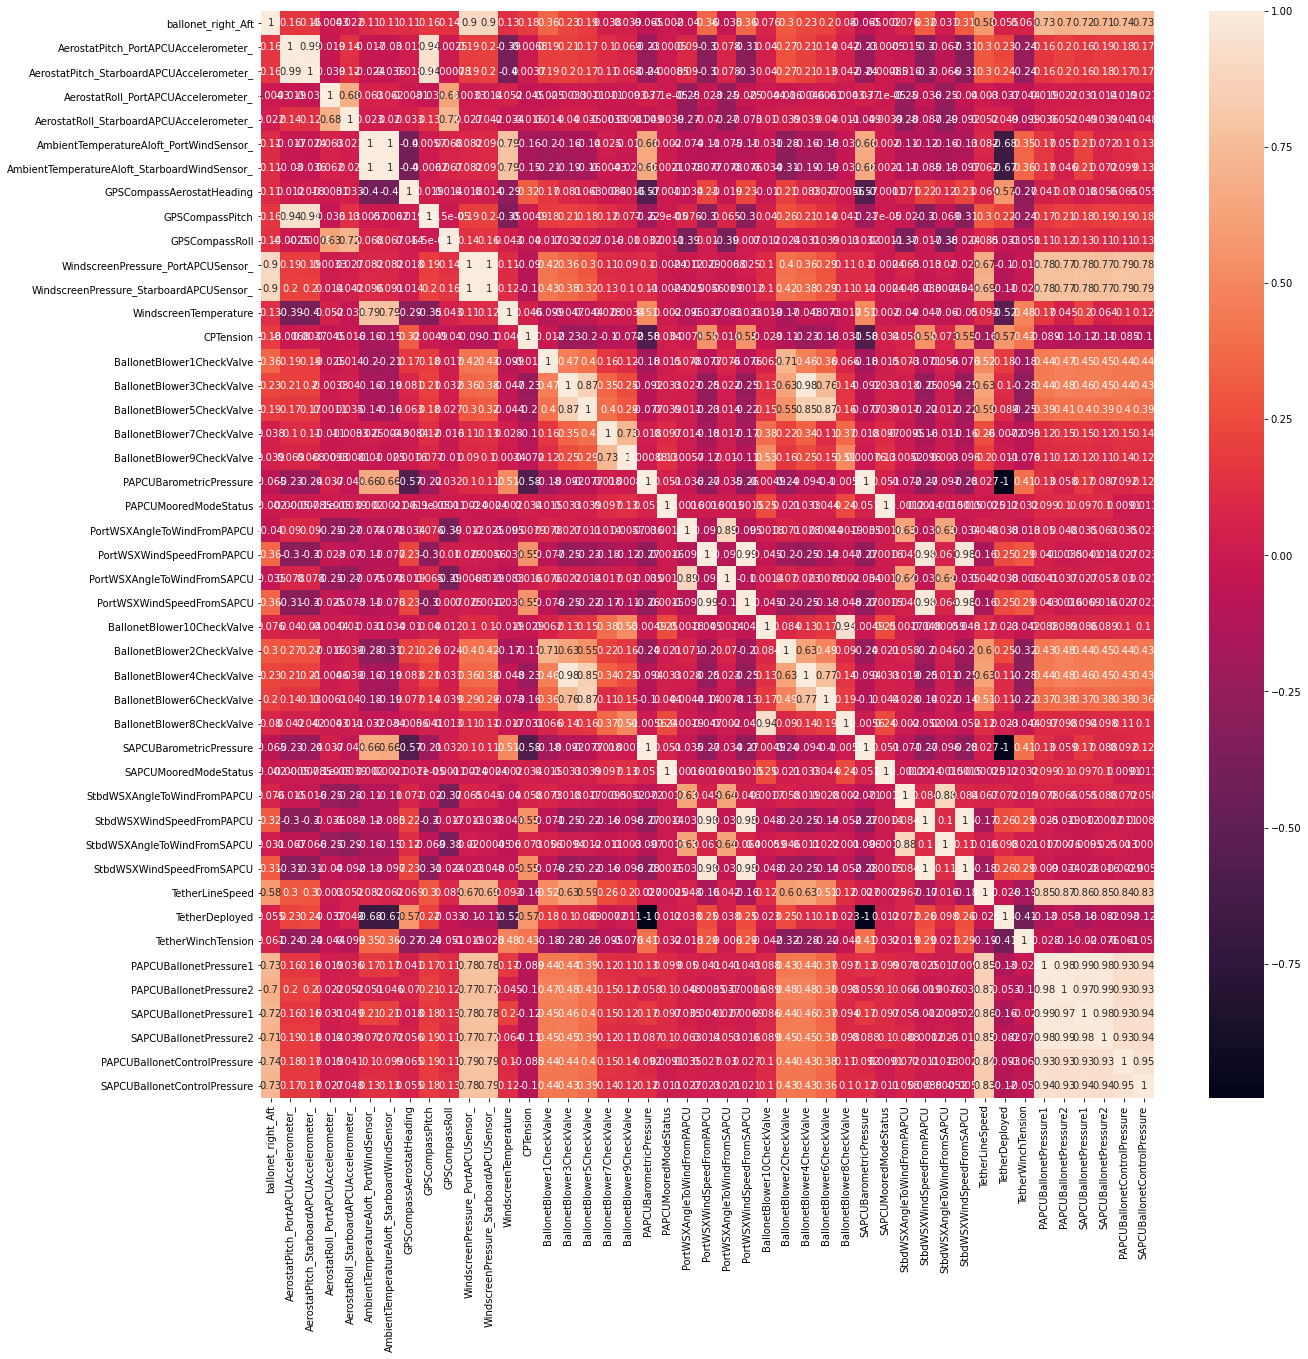

In [8]:
#in order to see if there are any features that are directly correlated to our target variable we will look at some correlations
#lets build a correlation matrix, although it might be very packed and hard to look at...
corr_mat = mainDF.corr()
plt.figure(figsize=(20,20))
sn.heatmap(corr_mat, annot=True)

We want to look at some specific scatter plots becuase it seems some of our features are very closely correlated.
We might want to drop some of them in order to simplify the problem, and because we also know the meaning of each sensor we can drop features in a smart calculated manner.
We won't drop features with high correlation to out target variable because that would just be plain stupid...
from the correlation matrix, one thing has already popped up - a lot of highly correlated features come from neighboring sensors that have the same job but are placed on oposed sides of the aircraft (hence the names 'port' and 'starboard' taken from marine lingo)

In [9]:
sorted_mat = pd.DataFrame(abs(corr_mat.unstack()).sort_values(ascending=False))
#we got a DF with multi-indices, we will turn them into columns so they will be easier to work with
sorted_mat = sorted_mat.reset_index()
sorted_mat = sorted_mat.rename(columns={"level_0":"pair1", "level_1":"pair2", 0:"corr"})
#because the DF is sorted by correlation absolute value, we can erase every second line (the pairs will be identicle but the other way around)
sorted_mat = sorted_mat[::2]
#also we can get rid of identical pairs (the multi-indices will be the same)
sorted_mat = sorted_mat[sorted_mat['pair1']!=sorted_mat['pair2']]
#now lets look at all the correlated pairs with a high correlation (over 0.8)
sorted_mat = sorted_mat[sorted_mat['corr']>0.8].reset_index(drop=True)
sorted_mat

,pair1,pair2,corr
0,SAPCUMooredModeStatus,PAPCUMooredModeStatus,1.000000
1,SAPCUBarometricPressure,PAPCUBarometricPressure,0.999978
2,SAPCUBarometricPressure,TetherDeployed,0.997424
3,TetherDeployed,PAPCUBarometricPressure,0.997414
4,WindscreenPressure_StarboardAPCUSensor_,WindscreenPressure_PortAPCUSensor_,0.996195
5,AmbientTemperatureAloft_PortWindSensor_,AmbientTemperatureAloft_StarboardWindSensor_,0.996164
6,StbdWSXWindSpeedFromPAPCU,StbdWSXWindSpeedFromSAPCU,0.995041
7,PortWSXWindSpeedFromSAPCU,PortWSXWindSpeedFromPAPCU,0.994851
8,PAPCUBallonetPressure1,SAPCUBallonetPressure1,0.986796
9,AerostatPitch_PortAPCUAccelerometer_,AerostatPitch_StarboardAPCUAccelerometer_,0.986572


what do we make of this?
1. identical sensors that are on opposite sides of the aircraft are almost exactly correlated
2. SAPCU and PAPCU sensors of the same kind are also highly correlated (the 'S' and 'P' in the names probably mean 'Starboard' and 'Port')

now lets look at all of the feature names and drop the irrelevent features

In [18]:
list(mainDF.columns)

['BallonetBlower1CheckValve',
 'GPSCompassPitch',
 'BallonetBlower3CheckValve',
 'CPTension',
 'StbdWSXWindSpeedFromPAPCU',
 'WindscreenTemperature',
 'BallonetBlower10CheckValve',
 'BallonetBlower2CheckValve',
 'AerostatPitch_StarboardAPCUAccelerometer_',
 'BallonetBlower6CheckValve',
 'BallonetBlower7CheckValve',
 'StbdWSXAngleToWindFromPAPCU',
 'SAPCUBarometricPressure',
 'TetherDeployed',
 'TetherLineSpeed',
 'StbdWSXWindSpeedFromSAPCU',
 'AmbientTemperatureAloft_StarboardWindSensor_',
 'AerostatRoll_StarboardAPCUAccelerometer_',
 'SAPCUBallonetPressure2',
 'BallonetBlower5CheckValve',
 'SAPCUBallonetPressure1',
 'BallonetBlower9CheckValve',
 'StbdWSXAngleToWindFromSAPCU',
 'BallonetBlower8CheckValve',
 'TetherWinchTension',
 'SAPCUBallonetControlPressure',
 'WindscreenPressure_StarboardAPCUSensor_',
 'ballonet_right_Aft',
 'GPSCompassRoll',
 'GPSCompassAerostatHeading',
 'BallonetBlower4CheckValve',
 'SAPCUMooredModeStatus']

in order to maintain some logical order, our target variable is the balonet sensor on the right side of the aircraft, also known as *starboard*, so we will drop the features from the left/*port* side.
the only *port* feature we will leave is the windscreen pressure

In [19]:
port_features = ['AerostatPitch_PortAPCUAccelerometer_',
                 'AerostatRoll_PortAPCUAccelerometer_',
                 'AmbientTemperatureAloft_PortWindSensor_',
                 'PAPCUBarometricPressure',
                 'PAPCUMooredModeStatus',
                 'PortWSXAngleToWindFromPAPCU',
                 'PortWSXWindSpeedFromPAPCU',
                 'PortWSXAngleToWindFromSAPCU',
                 'PortWSXWindSpeedFromSAPCU',
                 'PAPCUBallonetPressure1',
                 'PAPCUBallonetPressure2',
                 'PAPCUBallonetControlPressure',
                 'WindscreenPressure_PortAPCUSensor_']
#the relevant features are all but the features above
rel_features = list(set(list(mainDF.columns))-set(port_features))
mainDF = mainDF[rel_features]
mainDF.shape

(89341, 32)

__A second look at the correlation matrix:__

<AxesSubplot:>

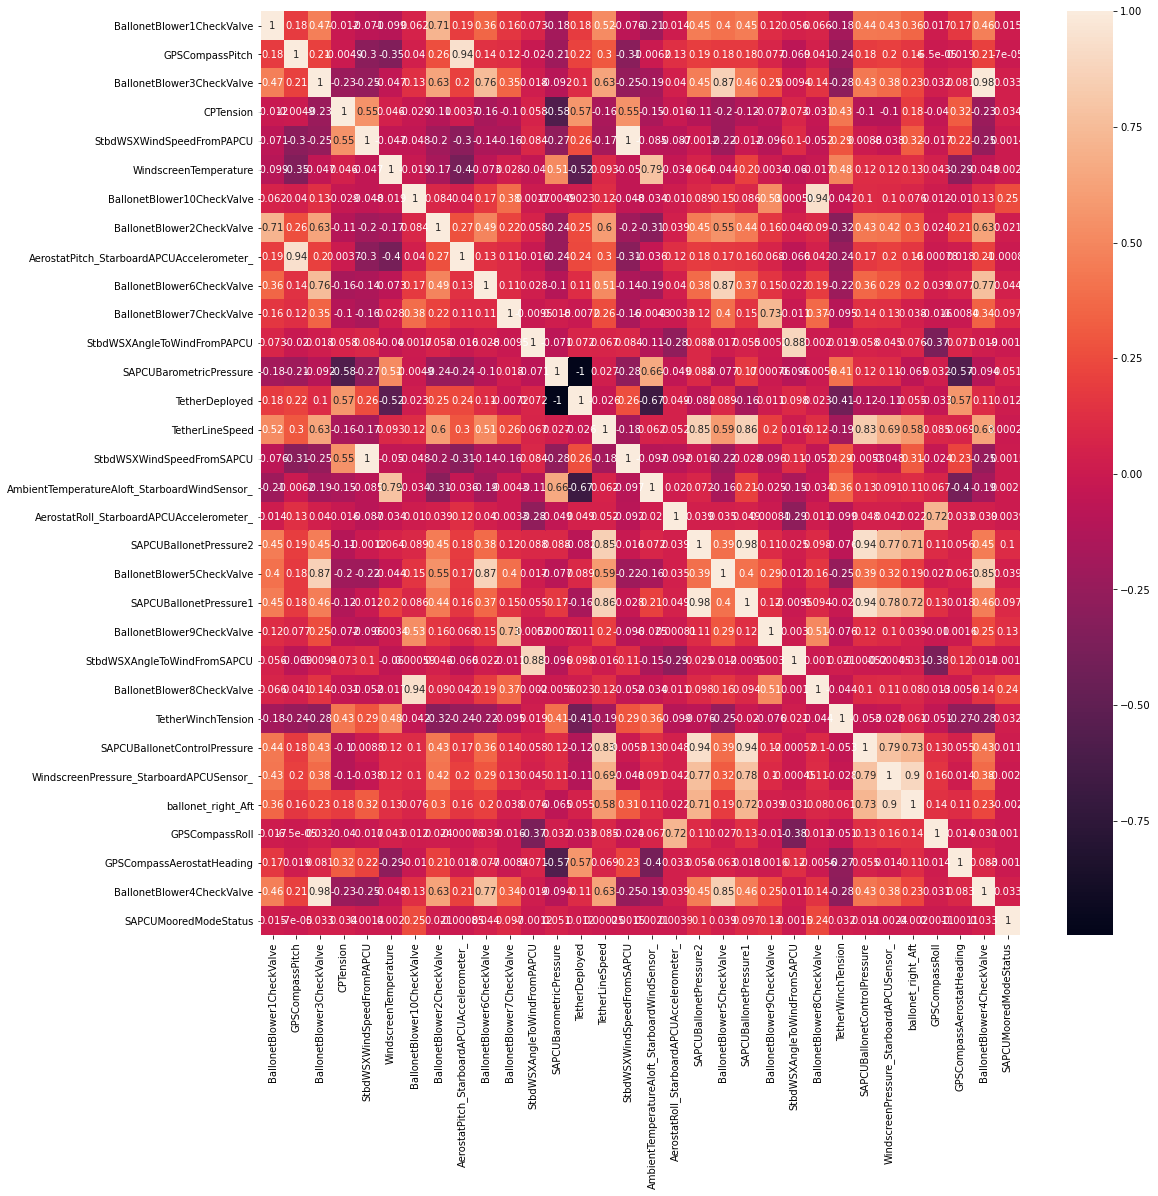

In [12]:
corr_mat2 = mainDF.corr()
plt.figure(figsize=(17,17))
sn.heatmap(corr_mat2, annot=True)

In [13]:
#lets look again at the correlations that are over 0.8
sorted_mat2 = pd.DataFrame(abs(corr_mat2.unstack()).sort_values(ascending=False))
#we got a DF with multi-indices, we will turn them into columns so they will be easier to work with
sorted_mat2 = sorted_mat2.reset_index()
sorted_mat2 = sorted_mat2.rename(columns={"level_0":"pair1", "level_1":"pair2", 0:"corr"})
#because the DF is sorted by correlation absolute value, we can erase every second line (the pairs will be identicle but the other way around)
sorted_mat2 = sorted_mat2[::2]
#also we can get rid of identical pairs (the multi-indices will be the same)
sorted_mat2 = sorted_mat2[sorted_mat2['pair1']!=sorted_mat2['pair2']]
#now lets look at all the correlated pairs with a high correlation (over 0.8)
sorted_mat2 = sorted_mat2[sorted_mat2['corr']>0.8].reset_index(drop=True)
sorted_mat2

,pair1,pair2,corr
0,SAPCUBarometricPressure,TetherDeployed,0.997424
1,StbdWSXWindSpeedFromSAPCU,StbdWSXWindSpeedFromPAPCU,0.995041
2,SAPCUBallonetPressure1,SAPCUBallonetPressure2,0.981745
3,BallonetBlower3CheckValve,BallonetBlower4CheckValve,0.978672
4,SAPCUBallonetControlPressure,SAPCUBallonetPressure1,0.939841
5,AerostatPitch_StarboardAPCUAccelerometer_,GPSCompassPitch,0.939574
6,BallonetBlower10CheckValve,BallonetBlower8CheckValve,0.936857
7,SAPCUBallonetControlPressure,SAPCUBallonetPressure2,0.935866
8,ballonet_right_Aft,WindscreenPressure_StarboardAPCUSensor_,0.895591
9,StbdWSXAngleToWindFromSAPCU,StbdWSXAngleToWindFromPAPCU,0.884395


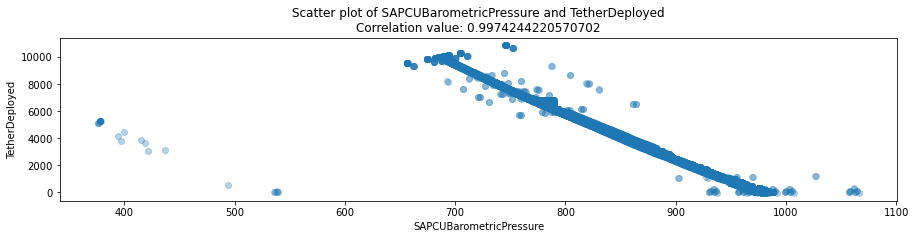

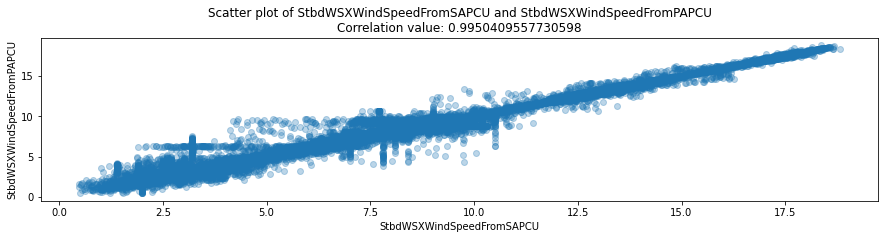

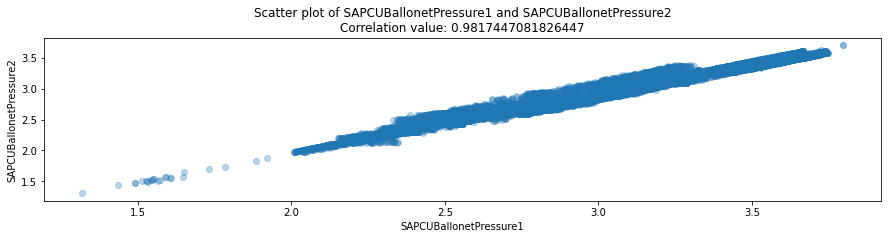

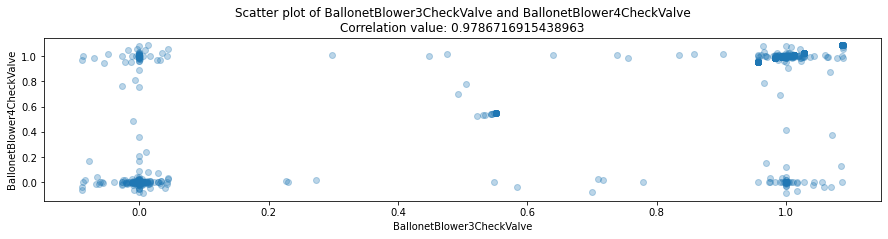

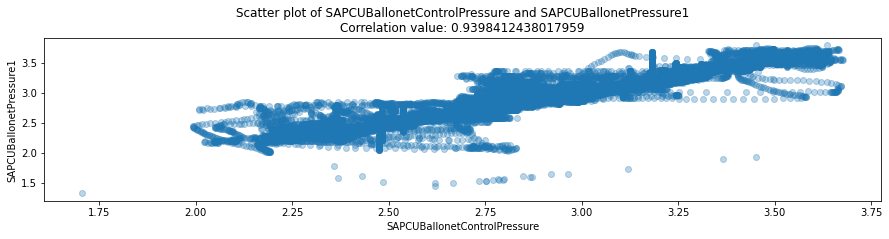

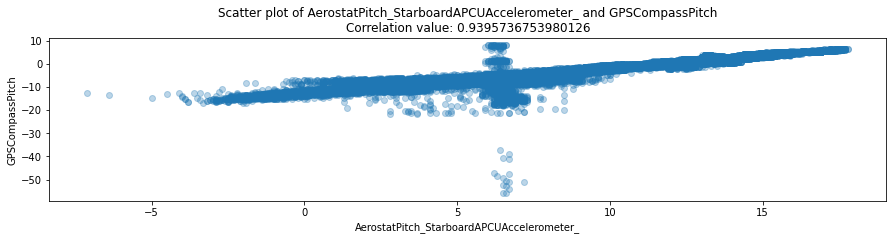

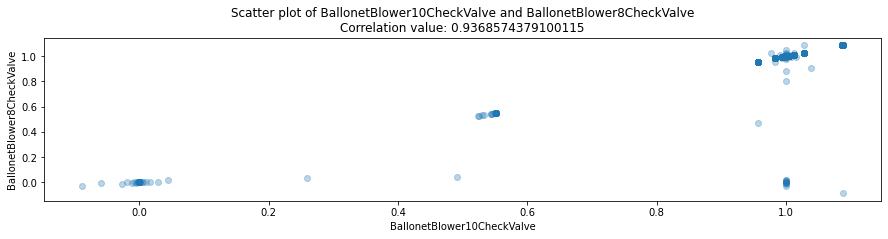

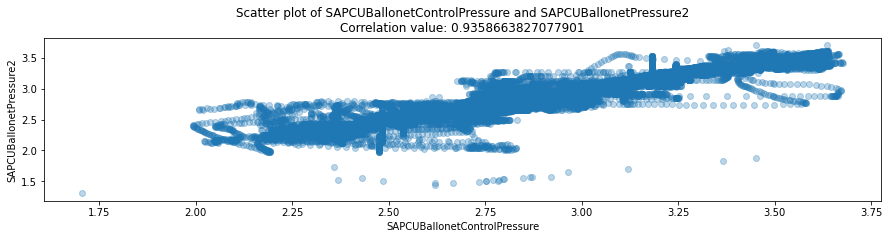

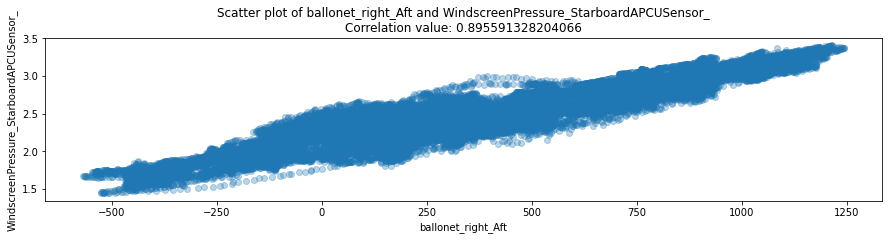

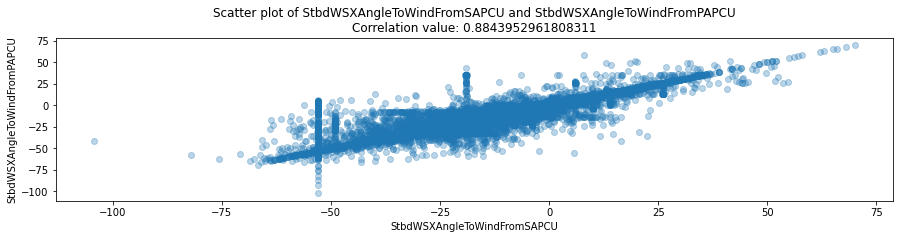

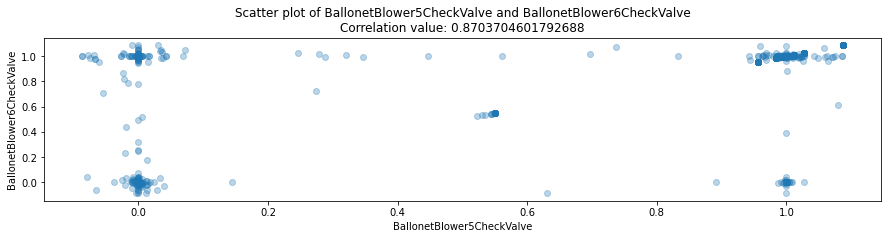

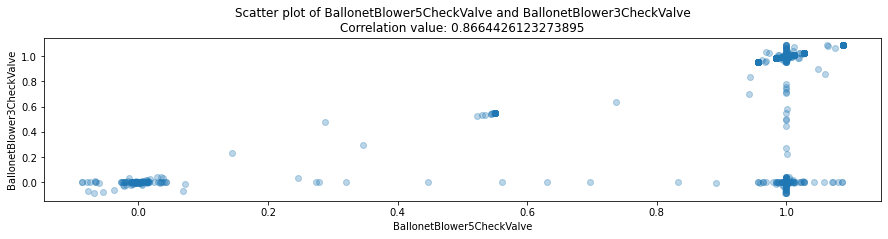

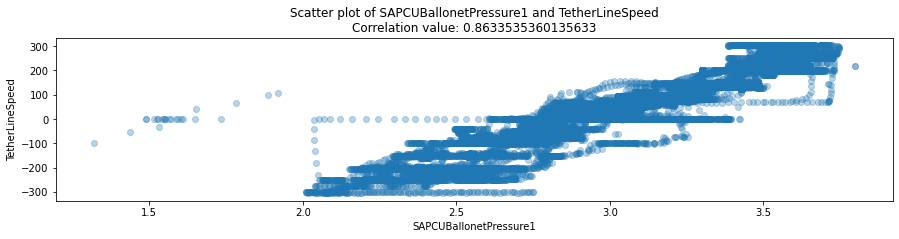

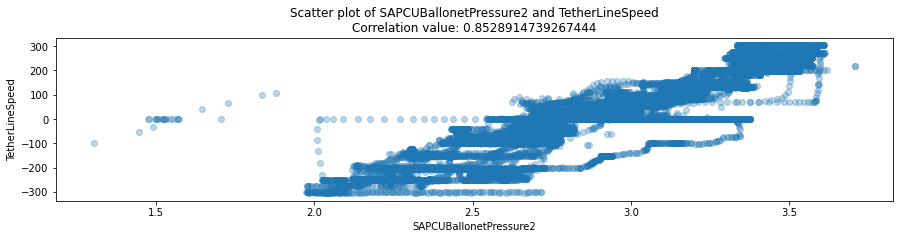

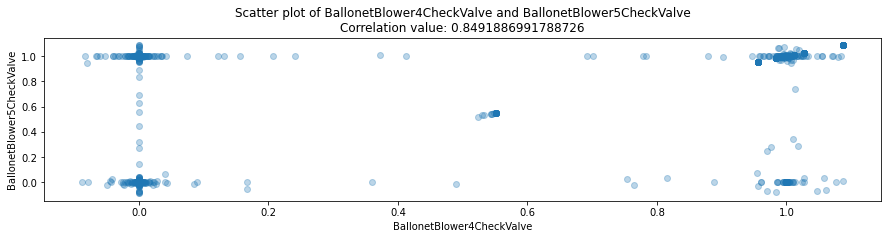

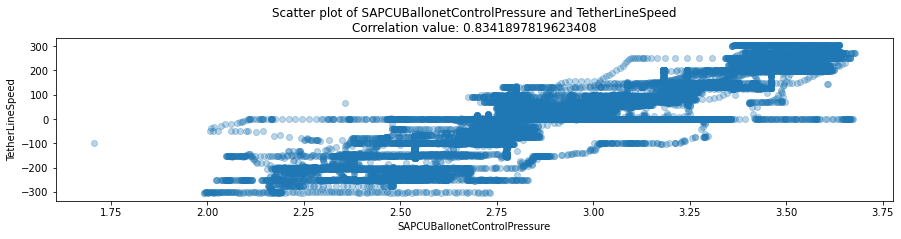

In [14]:
#lets look at satter lots of these pairs
for n in range(len(sorted_mat2)):
    plt.figure(figsize=(15,3))
    plt.scatter(mainDF[sorted_mat2['pair1'].iloc[n]], mainDF[sorted_mat2['pair2'].iloc[n]], alpha=0.3)
    plt.title('Scatter plot of '+str(sorted_mat2['pair1'].iloc[n])+
              ' and '+str(sorted_mat2['pair2'].iloc[n])+
              '\nCorrelation value: '+str(sorted_mat2['corr'].iloc[n]))
    plt.xlabel(sorted_mat2['pair1'].iloc[n])
    plt.ylabel(sorted_mat2['pair2'].iloc[n])

We can see that not all of these scatter plots are very linear but they still get a very high correlation value. In order to not lose any more data we will not drop any more features at this point (we might drop them later in the Linear Regression model using some sort of stepwise selection).
One more thing we would like to explore, that wil definantly help us with the Linear Regresision model, is th correlations of all the features with our target variable 'ballonet_right_Aft'.

<AxesSubplot:>

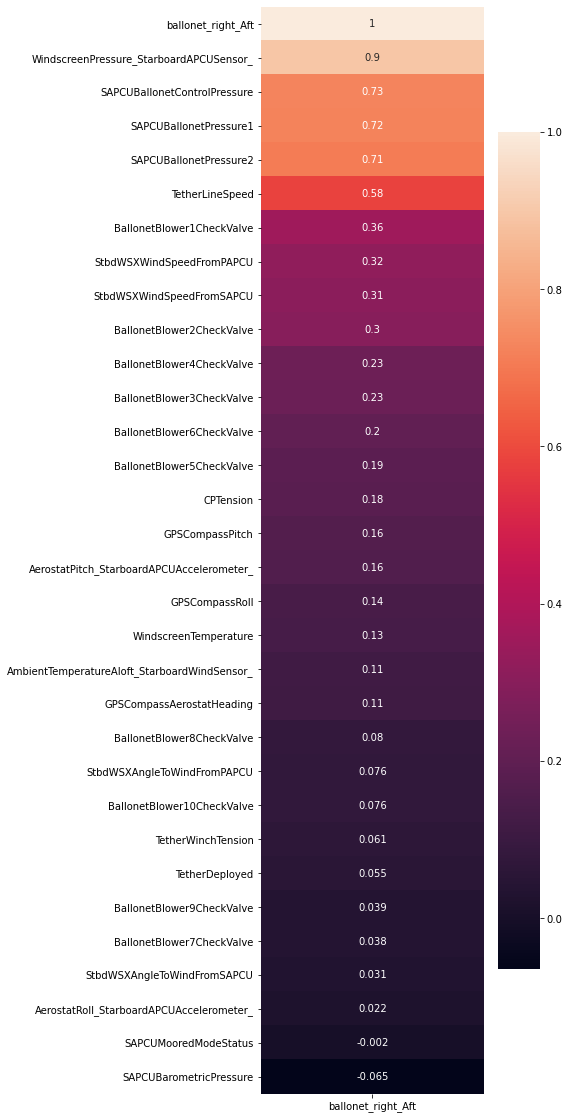

In [15]:
ynames = ['ballonet_right_Aft']
xnames = list(set(rel_features) - set(ynames)) #we defined rel_features already, it is the current column names of mainDF

corr_yx = corr_mat2[ynames].sort_values(by=['ballonet_right_Aft'], ascending=False)
plt.figure(figsize=(5,20))
sn.heatmap(corr_yx, annot=True)

After seeing the scatter plots and the correlation matrix, our guess is that when we use Linear Regression we will be able to model the target variable with Windscreenpressure and maybe a couple more features. This will be the topic of our next section which is training different models.

# Building Models

In this section we will be testing and comparing 3 different models - linear regression, random forest and a fully connected neural network.
We will devide mainDF into a 2/3 training set and a 1/3 test set. The test DF will be used for comparing the test MSE of all 3 models.

__Train-Test split:__

In [16]:
from sklearn.model_selection import train_test_split

X = mainDF[xnames] 
y = mainDF[ynames]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Before we start fitting models, we will create a baseline model that will just be the mean value of 'ballonte_right_Aft'.
Statisticaly, the mean value is an unbiased estimator.

In [17]:
y_pred_mean = numpy.full(y_test.shape, numpy.mean(y_train))
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
mean_MSE = mean_squared_error(y_test, y_pred_mean)
mean_R2 = abs(r2_score(y_test, y_pred_mean))
print('\nTest MSE of mean: '+str(mean_MSE))
print('\nR squared of mean: '+str(mean_R2))


Test MSE of mean: 64443.31034031133

R squared of mean: 2.150519423138597e-05


__Linear regression Model:__

In [20]:
from sklearn.preprocessing import StandardScaler

#we need to standartize our features for linear regression
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)

#we need to add column names and indices to the scaled data
scaled_X_train = pd.DataFrame(scaled_X_train, columns=[xnames], index=X_train.index)

In [21]:
from sklearn import  linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

#we will use sklearn to train the real model, but in order to do feature selection we use statmodels because of its summary
#in statmodels we need to add a constant term manualy to the regression
sm_train = sm.add_constant(scaled_X_train)

#train_linear = sm.add_constant(X)
#X2 = sm.add_constant((data[feature_names]-(data[feature_names].mean()))/(data[feature_names].std()))
est = sm.OLS(y_train, sm_train)
est2 = est.fit(random_seed=42)
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     ballonet_right_Aft   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 4.513e+04
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:14:17   Log-Likelihood:            -3.2116e+05
No. Observations:               59858   AIC:                         6.424e+05
Df Residuals:                   59826   BIC:                         6.427e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

We can see that tere are 3 features with a p-value larger than 0.05:
1. 'GPSCompassRoll'
2. 'BallonetBlower3CheckValve'
3. 'SAPCUBallonetPressure1'

We will drop these 3 features and than use sklearn's linear regression
Other than that, we get a pretty good R squared so ir seems a linear model should fit well here.

In [22]:
drop_features = ['GPSCompassRoll', 'BallonetBlower3CheckValve', 'SAPCUBallonetPressure1']
model_features = list(set(xnames)-set(drop_features))
scaler = StandardScaler()
scaler.fit(X_train[model_features])
#scale new train DF
scaled_X_train = scaler.transform(X_train[model_features])
scaled_X_train = pd.DataFrame(scaled_X_train, columns=[model_features], index=X_train.index)
#scale test DF
scaled_X_test = scaler.transform(X_test[model_features])
scaled_X_test = pd.DataFrame(scaled_X_test, columns=[model_features], index=X_test.index)

In [23]:
#now we build the model
LR_model = LinearRegression().fit(scaled_X_train, y_train)
#now we test our model on the test data
y_pred_LR = LR_model.predict(scaled_X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
LR_MSE = mean_squared_error(y_test, y_pred_LR)
LR_R2 = r2_score(y_test, y_pred_LR)
print('\nTest MSE of LR model: '+str(LR_MSE))
print('\nR squared of LR model: '+str(LR_R2))


Test MSE of LR model: 2673.4924882295045

R squared of LR model: 0.9585131494939305


__Random Forest Model:__

In [24]:
#when using tree based modesl we dont need to scale our data
#we will use our original features (before the feature selection of the linear regression)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#we will optimize our RF model's hyper-parameters using a randomized search on a grid of parameters.
#the best parameters will be chosen by 5-fold CV
random_grid = {'n_estimators': [50, 100, 150, 200],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 4]
               }
RF_model = RandomForestRegressor()
RF_random = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, n_jobs = -1)
RF_random.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [50, 100, 150, 200]},
                   verbose=2)

In [25]:
#get the best parameters and train the full model with them
n_estimators = RF_random.best_params_.get('n_estimators')
max_features = RF_random.best_params_.get('max_features')
min_samples_split = RF_random.best_params_.get('min_samples_split')
min_samples_leaf = RF_random.best_params_.get('min_samples_leaf')

print('Optimal parameters for Random Forest model:')
print('n_estimators: '+str(n_estimators))
print('max_features: '+str(max_features))
print('min_samples_split: '+str(min_samples_split))
print('min_samples_leaf: '+str(min_samples_leaf))

#train the model with the optimal parameters
RF_opt = RandomForestRegressor(n_estimators=n_estimators,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features)
RF_opt.fit(X_train, y_train.values.ravel())

Optimal parameters for Random Forest model:
n_estimators: 200
max_features: sqrt
min_samples_split: 2
min_samples_leaf: 1


RandomForestRegressor(max_features='sqrt', n_estimators=200)

In [26]:
#now we test our model on the test data
y_pred_RF = RF_opt.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
RF_MSE = mean_squared_error(y_test, y_pred_RF)
RF_R2 = r2_score(y_test, y_pred_RF)
print('\nTest MSE of RF model: '+str(RF_MSE))
print('\nR squared of RF model: '+str(RF_R2))


Test MSE of LR model: 96.82989590761038

R squared of LR model: 0.9984974083773478


We can look at the feature importance in a Random Forest model the same way we can look at feature importance in Linear Regression. The difference is that in LR the importance goes by the p-values and in RF the feature importance is calculated by how high in each tree the parameter is located - the higher they go, the more important they are

Text(0.5, 1.0, 'Random Forest Feature Importance')

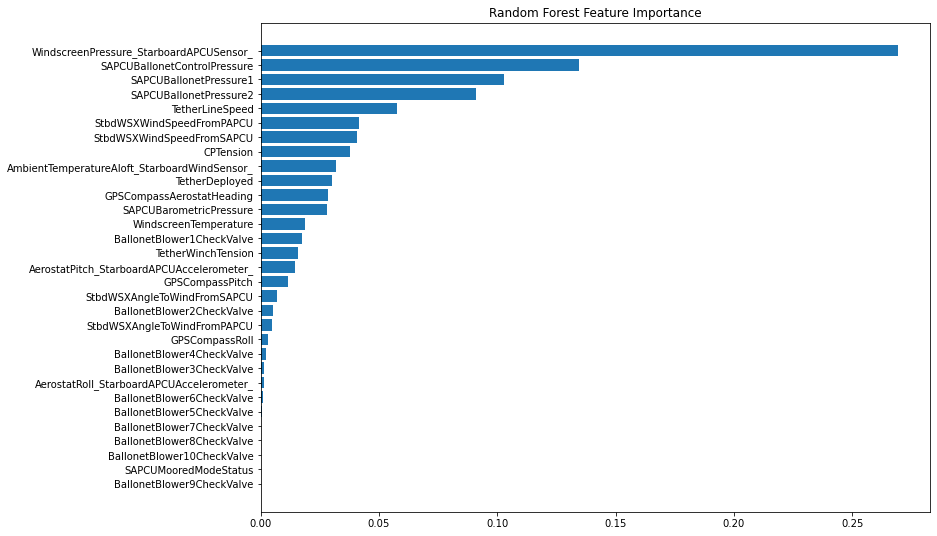

In [27]:
sorted_idx = RF_opt.feature_importances_.argsort()
plt.figure(figsize=(12,9))
plt.barh(X_test.columns[sorted_idx], RF_opt.feature_importances_[sorted_idx])
plt.title("Random Forest Feature Importance")

As we expect from most models, the screen pressure seems to be very important to the regression model.

We can see our model has a very high R squared value. we can show this graphicaly with a scatter plot between our target variable and the predicted value. We can see almost perfect linear behavior.

Text(0.5, 1.0, 'Predicted Value VS. True Value')

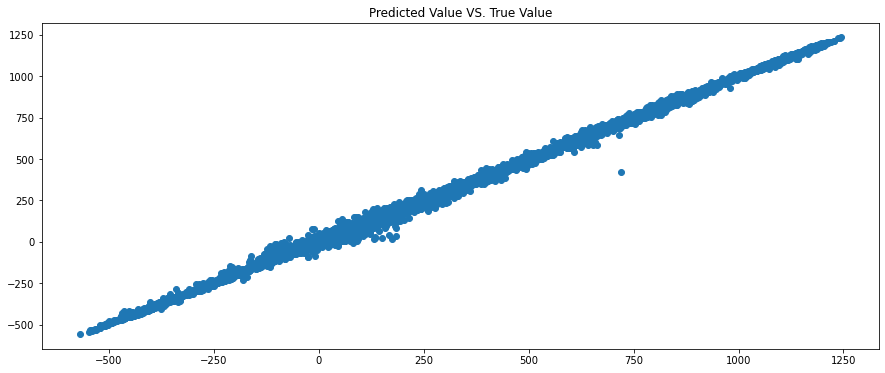

In [28]:
plt.figure(figsize=(15,6))
plt.scatter(numpy.array(y_test), y_pred_RF)
plt.title('Predicted Value VS. True Value')

# Regression Tree Model:

we want to fit this model for 2 reasons:
1. we want to see that the results of the random forest model really are better, and that its not just an overfit
2. we can visualize the tree and check our hypothesis that the windscreen pressure is the mosr important

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train.values.ravel())

DecisionTreeRegressor(random_state=42)

In [30]:
#now we test our model on the test data
y_pred_tree = tree_reg.predict(X_test)

# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
tree_MSE = mean_squared_error(y_test, y_pred_tree)
tree_R2 = r2_score(y_test, y_pred_tree)
print('\nTest MSE of tree regressor: '+str(tree_MSE))
print('\nR squared of tree regressor: '+str(tree_R2))


Test MSE of tree regressor: 227.58796263294101

R squared of tree regressor: 0.9964683245513861


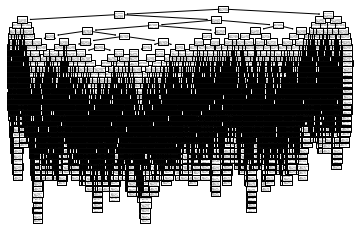

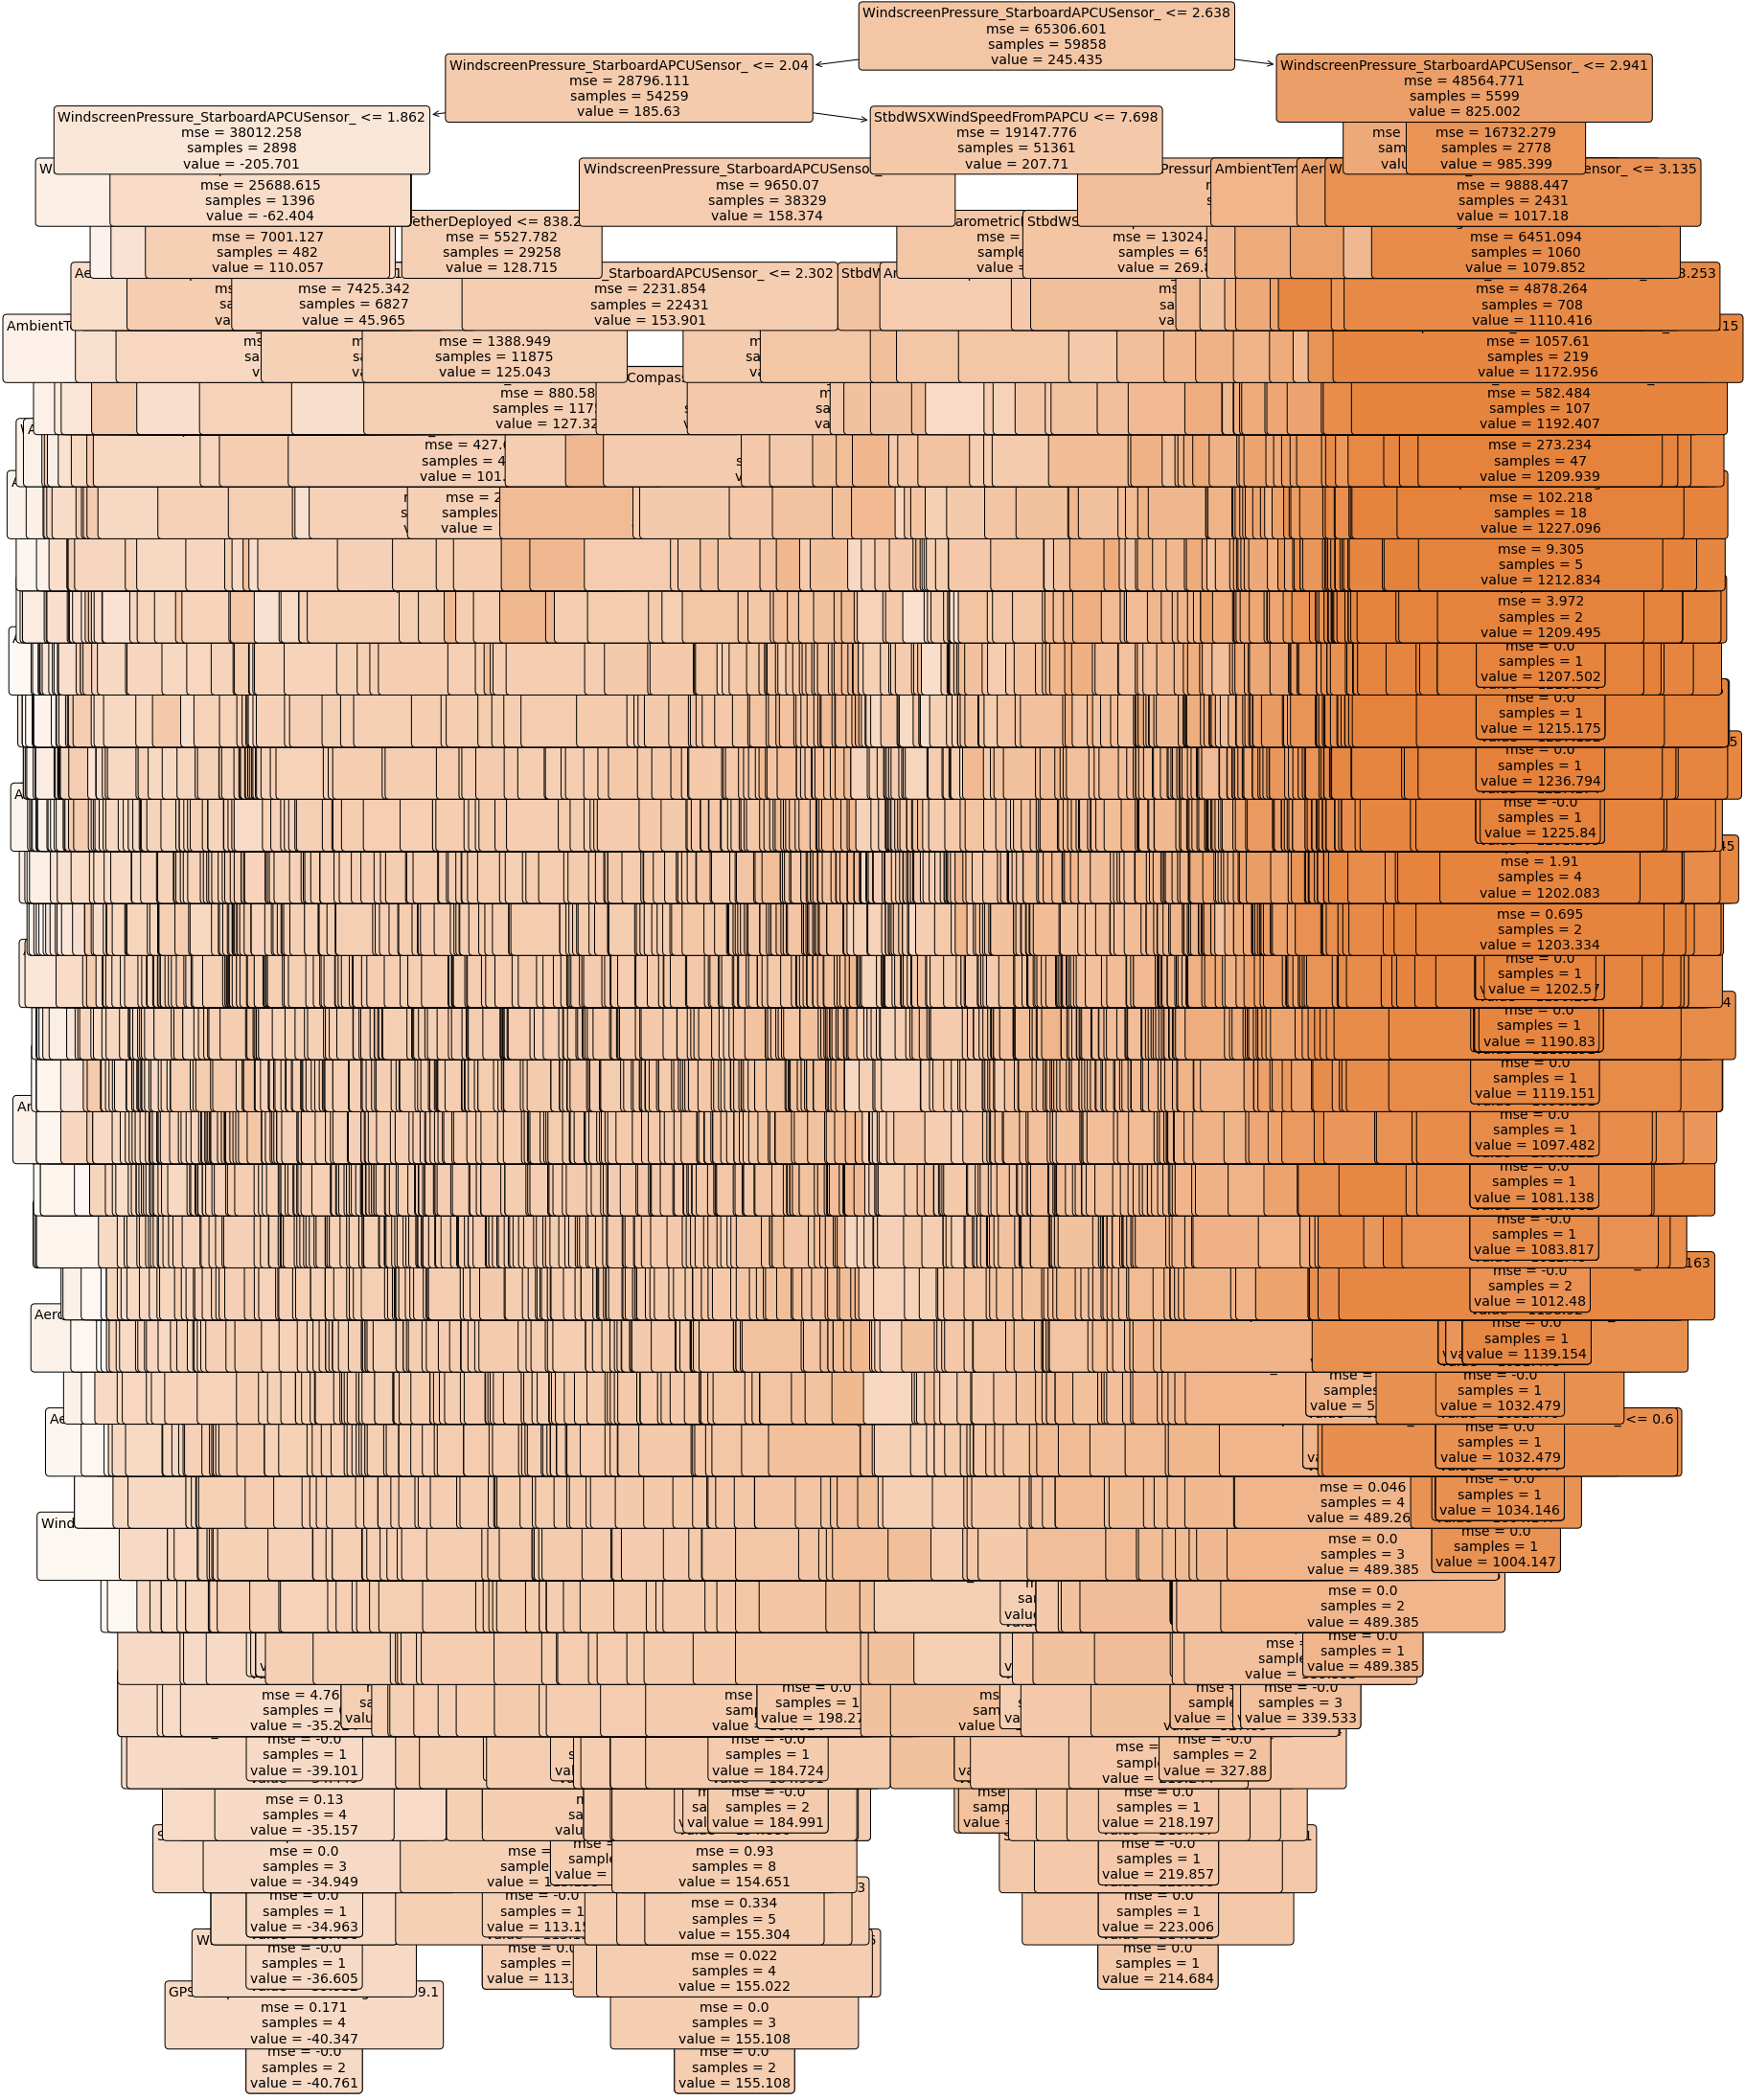

In [35]:
#tree regressors also have a plotting option so we can see the full tree
from sklearn import tree
tree.plot_tree(tree_reg);
plt.figure(figsize=(25,40))
a = tree.plot_tree(tree_reg, 
                   feature_names=X_test.columns,  
                   filled=True, 
                   rounded=True, 
                   fontsize=14)

__Neural Network Model:__

In nueral network architectures we must choose a sort of scaling:
1. 0 to 1 normalization
2. -1 to +1 normalization
3. standartization

We have decided to scale from 0 to 1 in this work.
notice - we also need to scale our target variable!

In [36]:
from sklearn.preprocessing import MinMaxScaler
#creating and fitting a scaler for the training data
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
#creating and fitting a scaler for the training target variable
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
#scaling X_train and y_train
norm_X_train = X_scaler.transform(X_train)
norm_y_train = y_scaler.transform(y_train)

In [37]:
from sklearn.neural_network import MLPRegressor

NN_model = MLPRegressor(solver='sgd',
                        activation='relu',
                        learning_rate_init=0.01,
                        hidden_layer_sizes=(60,30,),
                        verbose=True,
                        early_stopping=True)
NN_model.fit(norm_X_train, norm_y_train)

Iteration 1, loss = 0.01068674
Validation score: 0.661020
Iteration 2, loss = 0.00266029
Validation score: 0.807635
Iteration 3, loss = 0.00171585
Validation score: 0.865291
Iteration 4, loss = 0.00126021
Validation score: 0.896478
Iteration 5, loss = 0.00100068
Validation score: 0.914528
Iteration 6, loss = 0.00083367
Validation score: 0.927643
Iteration 7, loss = 0.00071285
Validation score: 0.936975
Iteration 8, loss = 0.00062204
Validation score: 0.944486
Iteration 9, loss = 0.00056198
Validation score: 0.948678
Iteration 10, loss = 0.00051989
Validation score: 0.952183
Iteration 11, loss = 0.00048902
Validation score: 0.954451
Iteration 12, loss = 0.00046623
Validation score: 0.956245
Iteration 13, loss = 0.00044946
Validation score: 0.957574
Iteration 14, loss = 0.00043540
Validation score: 0.958762
Iteration 15, loss = 0.00042334
Validation score: 0.959316
Iteration 16, loss = 0.00041407
Validation score: 0.960457
Iteration 17, loss = 0.00040463
Validation score: 0.961240
Iterat

MLPRegressor(early_stopping=True, hidden_layer_sizes=(60, 30),
             learning_rate_init=0.01, solver='sgd', verbose=True)

In [38]:
#scale X_test so we can predict on it
norm_X_test = X_scaler.transform(X_test)

#now we predict on the normalized test data
norm_y_pred_NN = NN_model.predict(norm_X_test)

#we need to invert the MinMaxScaler so we can compare y_pred and y_test
y_pred_NN = y_scaler.inverse_transform(norm_y_pred_NN.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
NN_MSE = mean_squared_error(y_test, y_pred_NN)
NN_R2 = r2_score(y_test, y_pred_NN)
print('\nTest MSE of NN model: '+str(NN_MSE))
print('\nR squared of NN model: '+str(NN_R2))


Test MSE of NN model: 1460.685294744805

R squared of NN model: 0.9773333073774136


# Optimization of RF model

In the last section we saw that the RF model had the best results.
We will perform a deeper optimization and show the results

In [39]:
X = mainDF[xnames] 
y = mainDF[ynames]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We use the same parameters we used for the RandomizedSearchCV, but this time we use GridSearchCV, which checks all the parameters and not randomly picks them.

In [40]:
from sklearn.model_selection import GridSearchCV

#we will optimize our RF model's hyper-parameters using a randomized search on a grid of parameters.
#the best parameters will be chosen by 5-fold CV
p_grid = {'n_estimators': [50, 100, 150, 200],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2],
          'min_samples_split': [2, 4]
               }
RF_model = RandomForestRegressor()
RF_random = GridSearchCV(estimator = RF_model, param_grid = p_grid, cv = 5, verbose=2, n_jobs = -1)
RF_random.fit(X_train, y_train.values.ravel())

allscores = RF_random.cv_results_['mean_test_score']
print(allscores)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[0.9979681  0.99803708 0.99804763 0.99806583 0.99795744 0.99800772
 0.99801301 0.99802227 0.99785945 0.99791056 0.9979369  0.9979323
 0.99784413 0.99791196 0.99793718 0.9979385  0.99813176 0.99825077
 0.99828234 0.99829466 0.99811139 0.99821275 0.99824    0.99824005
 0.99797578 0.99806005 0.99812039 0.99812384 0.99793765 0.99806876
 0.99810359 0.99812025]


In [41]:
opt_models = pd.DataFrame(RF_random.cv_results_['params'])
opt_models['mean_test_score'] = RF_random.cv_results_['mean_test_score']
opt_models = opt_models.sort_values(by=['mean_test_score'], ascending=False)
opt_models = opt_models.reset_index(drop=True)
opt_models

,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score
0,sqrt,1,2,200,0.998295
1,sqrt,1,2,150,0.998282
2,sqrt,1,2,100,0.998251
3,sqrt,1,4,200,0.998240
4,sqrt,1,4,150,0.998240
5,sqrt,1,4,100,0.998213
6,sqrt,1,2,50,0.998132
7,sqrt,2,2,200,0.998124
8,sqrt,2,2,150,0.998120
9,sqrt,2,4,200,0.998120


in the table above we can see the results of the optimization.
in the next section we will train the optimal model

In [42]:
#get the best parameters and train the full model with them
n_estimators = opt_models['n_estimators'][0]
max_features = opt_models['max_features'][0]
min_samples_split = opt_models['min_samples_split'][0]
min_samples_leaf = opt_models['min_samples_leaf'][0]

#train the model with the optimal parameters
RF_opt = RandomForestRegressor(n_estimators=n_estimators,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features)
RF_opt.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_features='sqrt', n_estimators=200)

In [43]:
#now we test our model on the test data
y_pred_RF = RF_opt.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# when compairing different models we usualy use r squred score of the test data, but we also claculated the test MSE just because we can...
opt_MSE = mean_squared_error(y_test, y_pred_RF)
opt_R2 = r2_score(y_test, y_pred_RF)
print('\nTest MSE of LR model: '+str(opt_MSE))
print('\nR squared of LR model: '+str(opt_R2))


Test MSE of LR model: 97.97413938257328

R squared of LR model: 0.998479652180838


As we did with the last RF we trained, we can now plot the importance plot. We expect the windsvreen pressure to still dominate over the other features as it did so far

Text(0.5, 1.0, 'Random Forest Feature Importance')

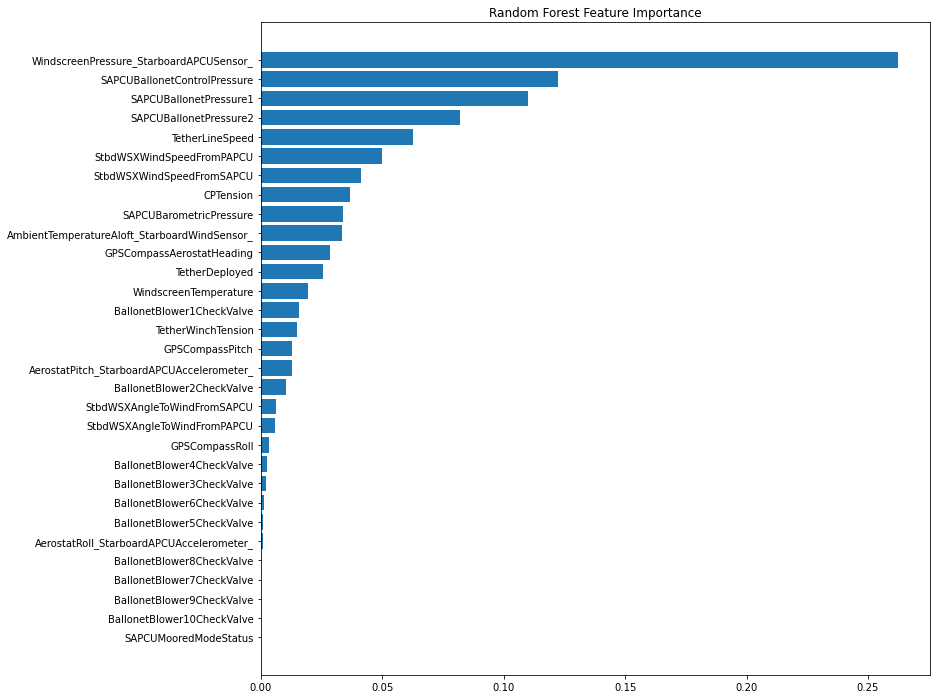

In [44]:
sorted_idx = RF_opt.feature_importances_.argsort()
plt.figure(figsize=(12,12))
plt.barh(X_test.columns[sorted_idx], RF_opt.feature_importances_[sorted_idx])
plt.title("Random Forest Feature Importance")

# Testing different train-test splits

in this section we will be training different train test splits, from a 10% train set to a 90% test set in 10% intervals.


In [45]:
R2_split = []
MSE_split = []
for perc in range(10,100,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=perc/100, random_state=42)
    RF_split = RandomForestRegressor(n_estimators=n_estimators,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features)
    RF_split.fit(X_train, y_train.values.ravel())
    y_pred_split = RF_split.predict(X_test)
    MSE_split.append(mean_squared_error(y_test, y_pred_split))
    R2_split.append(r2_score(y_test, y_pred_split))
    print('\nResults for '+str(perc/100)+' test set size:')
    print('Test MSE: '+str(MSE_split[-1]))
    print('R squared: '+str(R2_split[-1]))


Results for 0.1 test set size:
Test MSE: 74.17726347296713
R squared: 0.9988353685086283

Results for 0.2 test set size:
Test MSE: 80.7447114003318
R squared: 0.9987568094809798

Results for 0.3 test set size:
Test MSE: 88.73145686273922
R squared: 0.9986254969646733

Results for 0.4 test set size:
Test MSE: 105.34027966355245
R squared: 0.9983557982940808

Results for 0.5 test set size:
Test MSE: 118.42353043426581
R squared: 0.9981567746376134

Results for 0.6 test set size:
Test MSE: 134.83605017732094
R squared: 0.9979064325397283

Results for 0.7 test set size:
Test MSE: 177.23011383308057
R squared: 0.997262842284925

Results for 0.8 test set size:
Test MSE: 250.84319543379476
R squared: 0.9961378818127394

Results for 0.9 test set size:
Test MSE: 463.6987227099817
R squared: 0.9928556010696808


Text(0, 0.5, 'MSE')

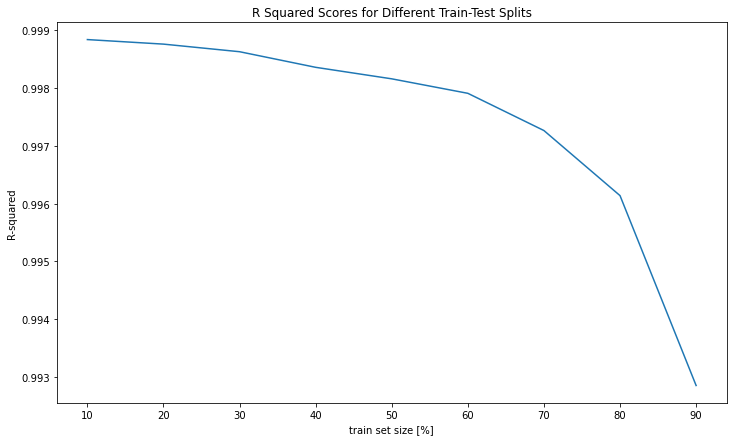

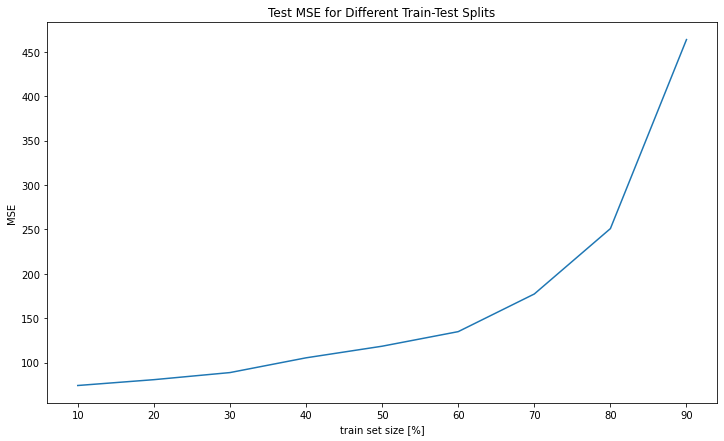

In [46]:
plt.figure(figsize=(12,7))
plt.plot(range(10,100,10), R2_split)
plt.title('R Squared Scores for Different Train-Test Splits')
plt.xlabel('train set size [%]')
plt.ylabel('R-squared')

plt.figure(figsize=(12,7))
plt.plot(range(10,100,10), MSE_split)
plt.title('Test MSE for Different Train-Test Splits')
plt.xlabel('train set size [%]')
plt.ylabel('MSE')

# Summary

In this work we trained 3 different regression models to the "balonet" data:
1. Linear regression
2. Random forest with 200 estimators
3. Neural network with 2 hidden layers of 60 and 30 neurons respectfully.

The model that achived the best score on the test set is the random forest model, so we used a GrinSearchCV to optimize it even more
we will compare all the model we trained in a table, including the mean value prediction which will be our baseline (and which didnt perform very well on the test set)

In [47]:
results = {'R2 score': [mean_R2, LR_R2, RF_R2, NN_R2, opt_R2], 
           'Test MSE': [mean_MSE, LR_MSE, RF_MSE, NN_MSE, opt_MSE]}

pd.DataFrame(results, index=['Mean of train set',
                             'Linear Regression', 
                             'Random Forest', 
                             'Neural Network', 
                             'Optimal Random Forest'])

,R2 score,Test MSE
Mean of train set,0.000022,64443.310340
Linear Regression,0.958513,2673.492488
Random Forest,0.998497,96.829896
Neural Network,0.977333,1460.685295
Optimal Random Forest,0.998480,97.974139
